In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib notebook

In [4]:
%matplotlib notebook

NOTES:
this code is written after the file: 
'command_temporal_order_analysis.ipynb'

To Do: 
The Vector Difference between movement-command activity and mean-command activity (move-mean) vs (shuffle-mean)
Individual Neuron Difference (mean, move, shuffle)
Example: for a chosen command and all shuffle distribution, move distribution, dotted line for global mean.
(The example is a tougher scenario... save till end.  That's because we'd like the activity to be for the same command without matching needed)


In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [6]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


In [63]:
# #Doublecheck numbers of trials:
# num_t_list = []
# m_accum = []
# for m in m_list:
#     m_p = (m[0],round(m[1]))
#     if m_p not in m_accum:
#         m_accum.append(m_p)
#         m_sel = (df.loc[:,'target']==m[0]) & (df.loc[:,'task']==round(m[1]))
#         num_t = df.loc[m_sel,'trial_cond'].max()+1
#         num_t_list.append(num_t)

In [7]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
        
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

<IPython.core.display.Javascript object>


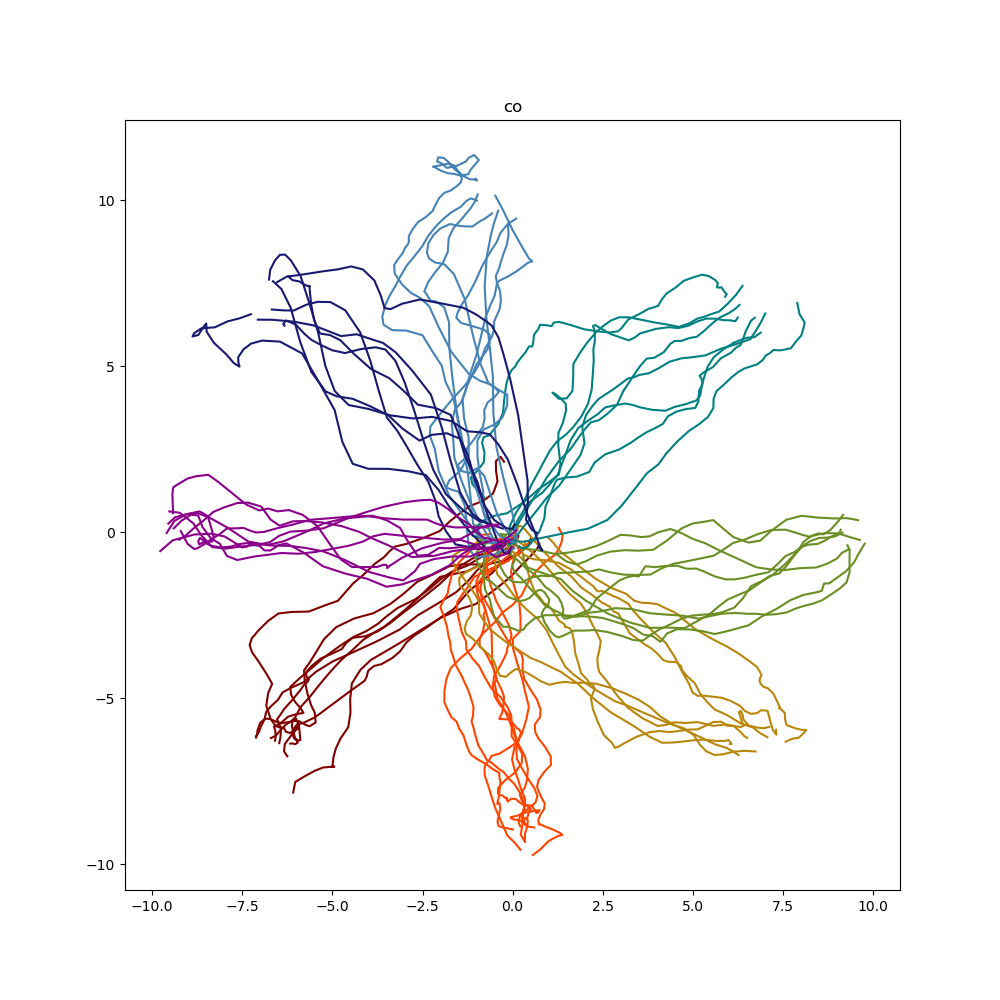

<IPython.core.display.Javascript object>


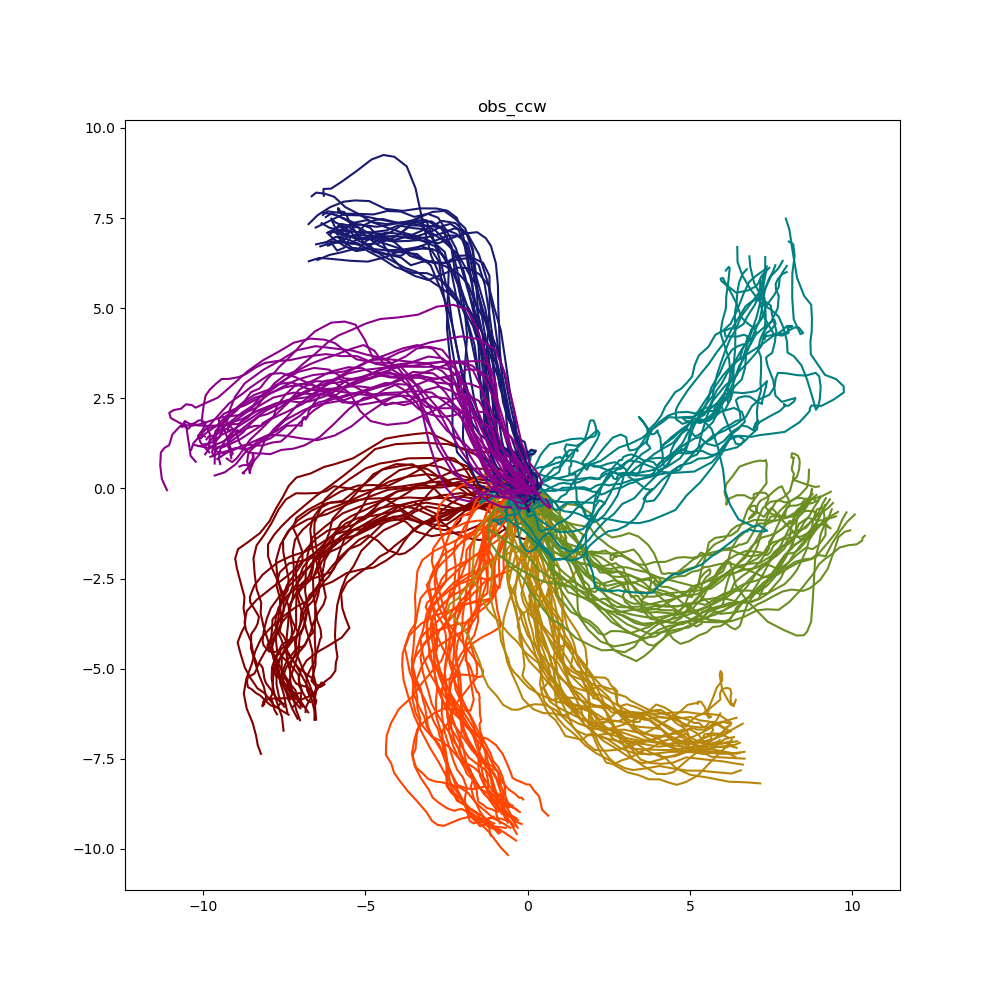

<IPython.core.display.Javascript object>


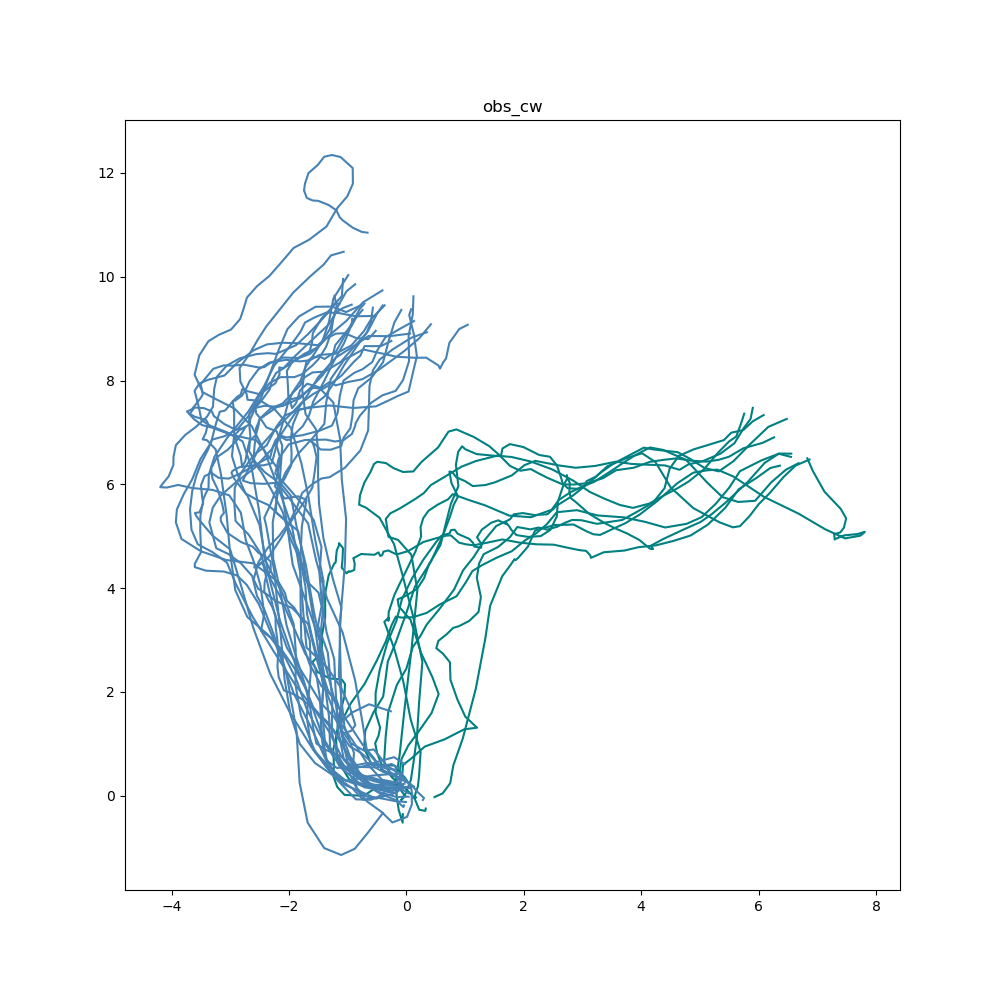

In [8]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [10]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)

<IPython.core.display.Javascript object>


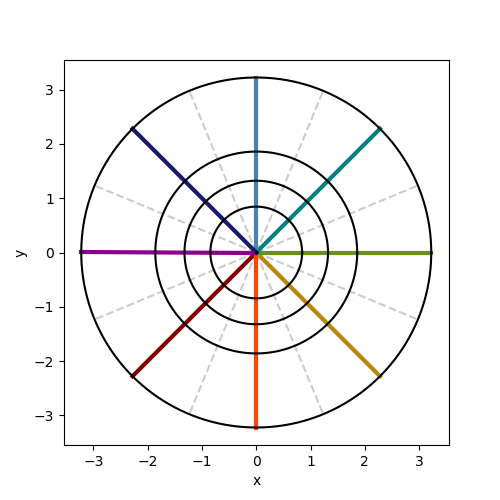

In [11]:
plt.figure(figsize=(5,5))
plot_command_bin()

In [12]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

#NOTE:
#cm_dic[c, 'sel'] pools only over the movements with enough observations, and only the samples
#after and before bin_buffer

bin_buffer = 0 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for c in c_list: 
    bm = c[0]
    ba = c[1]
    
    cm_dic[c] = []
    cm_dic[c,'num_obs'] = []
    #Loop over movement: 
    for m in move_list:
        sel = \
        (df['target']==m[0]) \
        & (df['task_rot']==m[1]) \
        & (df['bin'] >= bin_buffer) \
        & (df['bin_end'] >= bin_buffer) \
        & (df['u_v_mag_bin'] == bm) \
        & (df['u_v_angle_bin'] == ba)
        num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
        #ASSIGN:
        cm_dic[c,m,'sel'] = sel
        cm_dic[c,m,'num_obs'] = num_obs
        if num_obs >= min_obs:
            cm_dic[c].append(m)
            cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for c in c_list:
    bm = c[0]
    ba = c[1]
    cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
    for m in cm_dic[bm,ba]:
        cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
        | cm_dic[c,m,'sel']
#movement-pool sel wil be useful as the global mean for command-activity.



### For each command, identify the subset of the pool command distribution which matches command mean

In [231]:
#Loop command+movement: 
var = ['u_vx', 'u_vy'] #just to start with 
match_var = var
p_sig = 0.05

t_start = timeit.default_timer()

# c_list_d = [c_list[10]]
for c in c_list:
    c_idx = df[cm_dic[c,'sel']].index.values
    c_da = bmi_b.df_idx2da(df,c_idx,var)
    cm_list = cm_dic[c]
#     print(cm_list)
#     cm_list_d = [cm_list[0]]
    for m in cm_list:
        cm_idx = df[cm_dic[c,m,'sel']].index.values
        cm_da = bmi_b.df_idx2da(df,cm_idx,var)
        #match distributions:

#         print(c,m)
        success, kept_list, discard_list, df_match, ttest_r, mean_r = \
        bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=c_da, d_target=cm_da, p_sig=0.05, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)

#         d_list=[c_da, cm_da]
#         success, kept_list, discard_list, df_match, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean_v2(match_var, d_list, p_sig=p_sig, max_iter=max_discard)
        #kept_list: 
        #idx 0: idxs from c_da to keep 
        #idx 1: idxs from cm_da to keep
        
        cm_dic[c,m,'pool_match_idx'] = kept_list[0]
        cm_dic[c,m,'pool_match_success'] = success
        cm_dic[c,m,'pool_match_discard'] = discard_list[0]
        cm_dic[c,m,'pool_match_ttest'] = ttest_r
        cm_dic[c,m,'pool_match_mean'] = mean_r    
        
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)#/(60.0*60.0))

0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
316
0.9
299
0.85
283
0.8
266
0.75
249
0.7
233
0.65
216
0.6
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
291
0.9
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
291
0.9
276
0.85
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
305
0.9
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
319
0.9
302
0.85
285
0.8
matched!
0.95
matched!
0.95
319
0.9
302
0.85
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched!
0.95
matched

### Shuffle movement+time label of each command observation, to serve as a control

In [232]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
t_start = timeit.default_timer()
num_shuffle = 1000
for c in c_list:
    for m in cm_dic[c]:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        num_obs = cm_dic[c,m,'num_obs']
        shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
        for s in range(num_shuffle):
            shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
        #ASSIGN:
        cm_dic[c,m,'shuffle_mat'] = shuffle_mat
t_elapsed = timeit.default_timer()-t_start       
print(t_elapsed)

### Implement the analysis of comparing command-activity:

In [233]:
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]

In [234]:
#let's calculate the true vector diff vs shuffle vector diff:
#true mean, shuffle mean, pool-match mean
t_start = timeit.default_timer()
n_list = ['n_'+str(i) for i in range(num_neurons)]
mean_var = copy.copy(n_list)

num_shuffle = 1000

for c in c_list:
    for m in cm_dic[c]:
        print(c,m)
        #POOL:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        mu_c = df.loc[c_idxs, mean_var].mean()
        
        #MOVE:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        mu_cm = df.loc[cm_idxs, mean_var].mean()
        
        #SHUFFLE:
        nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
        s_mean = xr.DataArray(nan_mat, 
                          coords={'v':mean_var,'shuffle':range(num_shuffle)},
                          dims=['v','shuffle'])
        for s in range(num_shuffle):
            s_idxs = cm_dic[c,m,'shuffle_mat'][:,s]
            mu_s = df.loc[s_idxs, mean_var].mean()
            s_mean.loc[:,s] = mu_s
        
        #ASSIGN:
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
        cm_dic[c,m,'n_c'] = mu_c
        cm_dic[c,m,'n_cm'] = mu_cm
        cm_dic[c,m,'n_s'] = s_mean
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
        

((0, 0), (0, 0))
((0, 0), (0, 1.1))
((0, 0), (1, 0))
((0, 0), (1, 1.1))
((0, 0), (2, 0))
((0, 0), (2, 1.1))
((0, 0), (3, 1.1))
((0, 0), (4, 1.1))
((0, 0), (5, 1.2))
((0, 0), (6, 1.1))
((0, 0), (7, 1.1))
((0, 1), (0, 1.1))
((0, 1), (1, 0))
((0, 1), (1, 1.1))
((0, 1), (2, 0))
((0, 1), (2, 1.1))
((0, 1), (3, 1.1))
((0, 1), (4, 1.1))
((0, 1), (4, 1.2))
((0, 1), (7, 1.1))
((0, 2), (0, 1.1))
((0, 2), (1, 0))
((0, 2), (1, 1.1))
((0, 2), (2, 0))
((0, 2), (2, 1.1))
((0, 2), (3, 0))
((0, 2), (3, 1.1))
((0, 2), (4, 1.1))
((0, 2), (5, 1.2))
((0, 3), (1, 1.1))
((0, 3), (2, 0))
((0, 3), (2, 1.1))
((0, 3), (3, 0))
((0, 3), (3, 1.1))
((0, 3), (4, 1.1))
((0, 3), (4, 1.2))
((0, 3), (5, 1.2))
((0, 4), (1, 1.1))
((0, 4), (2, 1.1))
((0, 4), (3, 0))
((0, 4), (3, 1.1))
((0, 4), (4, 0))
((0, 4), (4, 1.1))
((0, 4), (4, 1.2))
((0, 4), (5, 1.2))
((0, 5), (1, 1.1))
((0, 5), (2, 1.1))
((0, 5), (3, 1.1))
((0, 5), (4, 1.1))
((0, 5), (4, 1.2))
((0, 5), (5, 1.2))
((0, 6), (0, 1.1))
((0, 6), (1, 1.1))
((0, 6), (2, 1.1)

### Calculate which command-movement activity is sig different from command-pool activity

In [237]:
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        #Vec Diff: 
        cm_dic[c,m,'n_diff_true'] = cm_dic[c,m,'n_c'] - cm_dic[c,m,'n_cm']
        n_c_rep = np.array(cm_dic[c,m,'n_c'])[...,None]
        cm_dic[c,m,'n_diff_s'] = n_c_rep-cm_dic[c,m,'n_s']
        
        #Norm Diff: 
        cm_dic[c,m,'n_diff_norm_true'] = np.linalg.norm(cm_dic[c,m,'n_diff_true'], axis=0)
        cm_dic[c,m,'n_diff_norm_s'] = np.linalg.norm(cm_dic[c,m,'n_diff_s'], axis=0)
        

### Save Results

In [238]:
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
save_path = os.path.join(save_dir, 'mean_analysis_shuffle1000_update.pkl')

with open(save_path, 'wb') as f: 
    data = pickle.dump(cm_dic, f, protocol=pickle.HIGHEST_PROTOCOL)


### Load results

In [13]:
# Test load the results
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
save_path = os.path.join(save_dir, 'mean_analysis_shuffle1000_update.pkl')
with open(save_path, 'rb') as f: 
    test = pickle.load(f)
# np.sum(np.array(test['p'])<=0.05)/float(len(test['p']))  


#if you want to use the loaded results: 
use_loaded_results = True
if use_loaded_results:
    cm_dic = test

In [14]:
#Get the observations of data
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
        
#
num_shuffle=1000

### Stats

### Fraction of significant command-movements

In [18]:
num_shuffle=1000

<IPython.core.display.Javascript object>


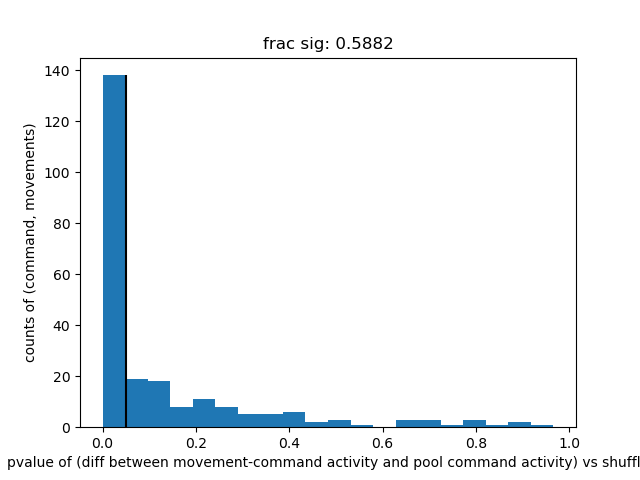

Text(0,0.5,'counts of (command, movements)')

In [19]:
#Count how many shuffle diffs are greater than true diff, and divide by number of shuffles for pval
#TODO: Make a data frame for each (c,m) to store the results
cm_dic['p'] = []
for c in c_list:
    for m in cm_dic[c]:
        num = np.sum((cm_dic[c,m,'n_diff_norm_s']-cm_dic[c,m,'n_diff_norm_true'])>0)
        p = float(num)/num_shuffle
        cm_dic[c,m,'p'] = p
        cm_dic['p'].append(p)        
            
p_sig =0.05
frac_sig = float(np.sum(np.array(cm_dic['p'])<=p_sig))/len(cm_dic['p'])

plt.figure()
n,bins,patch=plt.hist(cm_dic['p'],20)
plt.vlines(0.05, 0, n.max() )
plt.title('frac sig: ' + str(round(frac_sig,4)))
plt.xlabel('pvalue of (diff between movement-command activity and pool command activity) vs shuffle')
plt.ylabel('counts of (command, movements)')

### Fraction of significant (neuron-command-movements) and (neurons)

In [20]:
cm_dic[c,m,'n_c']/sample_period

n_0     11.951220
n_1      5.365854
n_2      0.262664
n_3      0.450281
n_4     17.166979
n_5     26.397749
n_6     17.485929
n_7      2.739212
n_8      0.262664
n_9      0.018762
n_10     0.131332
n_11    19.587242
n_12     0.525328
n_13     0.150094
n_14    12.363977
n_15    19.737336
n_16     6.210131
n_17     7.354597
n_18    12.814259
n_19     6.566604
n_20     4.878049
n_21    16.866792
n_22    15.666041
n_23    18.273921
n_24     5.684803
n_25     5.966229
n_26    15.084428
n_27    22.682927
n_28    10.900563
n_29     6.172608
n_30    14.108818
n_31    16.378987
n_32    24.333959
n_33    11.707317
n_34     7.410882
n_35    19.174484
n_36    21.106942
n_37    17.091932
n_38    25.666041
n_39    25.572233
n_40     1.557223
n_41    70.318949
n_42     6.735460
n_43    10.075047
dtype: float64

In [257]:
#(neuron-command-movements)

#(neurons sig modulated for at least one command-movement)
# rn = []
num_ncm = 0
num_cm = 0
num_sig_ncm = 0
n_num_sig_cm = pd.DataFrame(data=np.ones((1,44)),columns=n_list)
p_sig = 0.05

sample_period = 0.1
min_fr = 0.5

for c in c_list:
    for m in cm_dic[c]:
        true = np.abs(cm_dic[c,m,'n_diff_true'])
        s_mat = np.abs(cm_dic[c,m,'n_diff_s'])
        mat_t_minus_s = np.array(true).reshape((-1,1))-s_mat
        num = (mat_t_minus_s<0).sum(axis=1)
        pn = num/float(num_shuffle)
        
        #set to nan if the command mean is too low: 
#         pn.loc[(cm_dic[c,m,'n_c'] <= min_fr)]= np.nan
        cm_dic[c,m,'p_n'] = pn
        
        
        
        cm_dic[c,m,'num_sig_n'] = np.sum((pn<p_sig)&(cm_dic[c,m,'n_c']>=min_fr))
        
        num_valid_neurons = np.sum((cm_dic[c,m,'n_c']>=min_fr))
        num_ncm += num_valid_neurons #num_neurons
        num_cm += 1
        num_sig_ncm += cm_dic[c,m,'num_sig_n']
        
        n_num_sig_cm += (pn<p_sig)&(cm_dic[c,m,'n_c']>=min_fr)
frac_sig_ncm = float(num_sig_ncm)/num_ncm

In [244]:
#Fraction of significant (neuron,command,movement):
print(frac_sig_ncm)

0.12958238216731569


In [88]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\command_activity_diff'

        n_0       n_1       n_2       n_3      n_4       n_5      n_6  \
0  0.172269  0.012605  0.004202  0.004202  0.12605  0.105042  0.07563   

        n_7       n_8       n_9  ...      n_34     n_35      n_36      n_37  \
0  0.004202  0.004202  0.004202  ...  0.016807  0.10084  0.273109  0.201681   

       n_38      n_39      n_40      n_41      n_42      n_43  
0  0.403361  0.117647  0.264706  0.294118  0.176471  0.180672  

[1 rows x 44 columns]


<IPython.core.display.Javascript object>


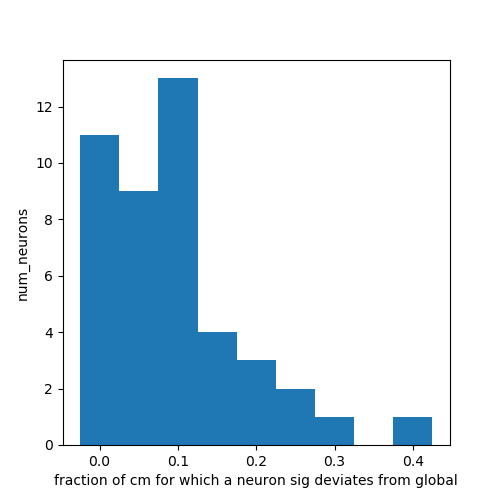

In [245]:
#For each neuron, for what fraction of (command,movements) does it sig deviate from command-global? 
#TODO: only evaluate for valid neurons... for now this hist includes neurons which don't sig deviate because they have too low of fr


fig_name = 'hist_frac_cm_that_n_is_sig'
save_bool = False

n_frac_sig_cm = n_num_sig_cm/float(num_cm)
print(n_frac_sig_cm)


bin_e = np.arange(0,0.5,0.05)-0.025

plt.figure(figsize=(5,5))
_=plt.hist(n_frac_sig_cm,bins=bin_e)
plt.xlabel('fraction of cm for which a neuron sig deviates from global')
plt.ylabel('num_neurons')

if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name))
        

In [247]:
n_num_sig_cm

n_0  n_1  n_2  n_3   n_4   n_5   n_6  n_7  n_8  n_9  ...  n_34  n_35  \
0  41.0  3.0  1.0  1.0  30.0  25.0  18.0  1.0  1.0  1.0  ...   4.0  24.0   

   n_36  n_37  n_38  n_39  n_40  n_41  n_42  n_43  
0  65.0  48.0  96.0  28.0  63.0  70.0  42.0  43.0  

[1 rows x 44 columns]

In [246]:
#Fraction of neurons which are sig for at least one c-m:
n_frac_sig = np.sum(n_num_sig_cm>0,axis=1)/num_neurons
print(n_frac_sig)

0    1.0
dtype: float64


In [23]:
#Get the observations of data
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]

### Hist/Scatter mean diffs 

In [248]:
num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

### Population vector

In [32]:
#Metric for the whole day: 
#Compute for true data and average over shuffle (?)
#1) change from global mean
#for each command-movement, do: norm(global_mean-data_mean)
#2) frac change from global mean
#for each command-movement, do: norm(global_mean-data_mean)/(norm(global_mean))

In [33]:
columns = \
['shuffle_diff_norm', 'true_diff_norm', 'global_norm',\
 'command_idx', 'movement_idx',  'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']

df_test = pd.DataFrame(index=[0], columns=columns)

In [35]:
#Make dataframe of results: 
columns = \
['shuffle_diff_norm', 'true_diff_norm', 'global_norm', 'true_frac_diff_norm', 'shuffle_frac_diff_norm', \
 'command_idx', 'movement_idx',  'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']
p_sig = 0.05
r = []

for c in c_list:
    for m in cm_dic[c]:
        diff_df = pd.DataFrame(index=[0],columns=columns)
        
        #RESULTS:
        diff_df.loc[0,'true_diff_norm'] = cm_dic[c,m,'n_diff_norm_true']
        diff_df.loc[0,'shuffle_diff_norm'] = cm_dic[c,m,'n_diff_norm_s'].mean()
        
        diff_df.loc[0,'global_norm'] = np.linalg.norm(cm_dic[c,m,'n_c'])
        diff_df.loc[0,'true_frac_diff_norm'] = cm_dic[c,m,'n_diff_norm_true']/diff_df.loc[0,'global_norm']
        diff_df.loc[0,'shuffle_frac_diff_norm'] = cm_dic[c,m,'n_diff_norm_s'].mean()/diff_df.loc[0,'global_norm']
        
        #RELATED VAR:
        diff_df.loc[0,'command_idx'] = c2idx[c]
        diff_df.loc[0,'movement_idx'] = m2idx[m]
        diff_df.loc[0,'u_v_mag_bin'] = c[0]
        diff_df.loc[0,'u_v_angle_bin'] = c[1]
        diff_df.loc[0,'p'] = cm_dic[c,m,'p']
        diff_df.loc[0,'sig'] = cm_dic[c,m,'p']<=p_sig
        
        r.append(diff_df)

r = pd.concat(r,ignore_index=True)

<IPython.core.display.Javascript object>


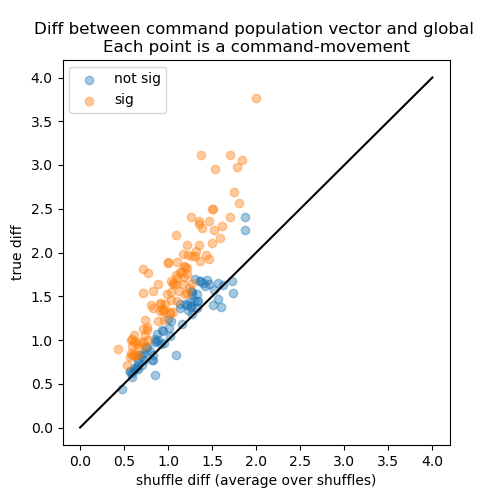

In [36]:
fig_name = 'scatter_vector_diff_true_vs_shuffle'
save_bool = False

# s_nsig = r.loc[:,'shuffle_diff_norm']
# d_nsig = r.loc[:,'true_diff_norm']

bm_sel = r.loc[:, 'u_v_mag_bin'] >=0
extra_sel = bm_sel

sel = (r.loc[:,'sig']==0)&extra_sel
s_nsig = r.loc[sel,'shuffle_diff_norm']
d_nsig = r.loc[sel,'true_diff_norm']

sel = (r.loc[:,'sig']==1)&extra_sel
s_sig = r.loc[sel,'shuffle_diff_norm']
d_sig = r.loc[sel,'true_diff_norm']


plt.figure(figsize=(5,5))
# plt.scatter(s,d,alpha=0.4)
plt.scatter(s_nsig,d_nsig,alpha=0.4, label='not sig')
plt.scatter(s_sig,d_sig,alpha=0.4, label='sig')
plt.legend()
plt.plot([0,4], [0,4],color='k')
plt.xlabel('shuffle diff (average over shuffles)')
plt.ylabel('true diff')
plt.title('Diff between command population vector and global \nEach point is a command-movement')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


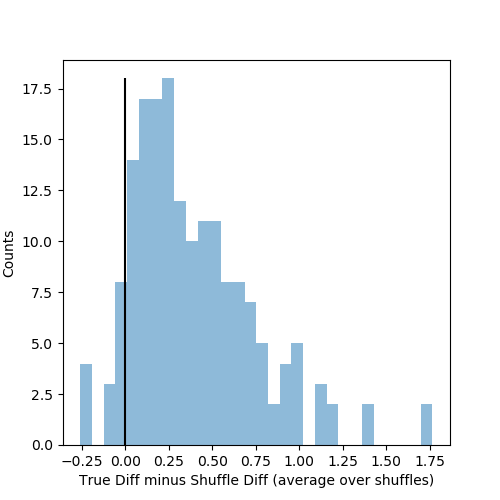

<IPython.core.display.Javascript object>


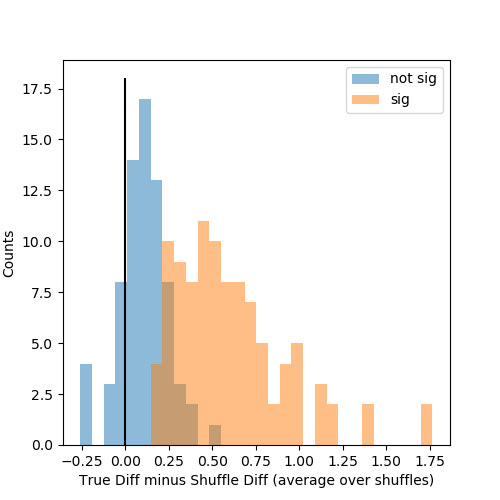

In [37]:
#Histogram of differences
#All and just significant: 


fig_name = 'hist_vector_diff_true_minus_shuffle'
save_bool = False

#ALL DATA:
s = r.loc[:,'shuffle_diff_norm']
d = r.loc[:,'true_diff_norm']
diff_df = d-s
diff=list(d-s)
plt.figure(figsize=(5,5))
n_all,bins,_ = plt.hist(diff,bins=30,alpha=0.5)
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


fig_name = 'hist_vector_diff_true_minus_shuffle_sig'
save_bool = True
        
#NOT SIG and SIG:
sel = (r.loc[:,'sig']==0)
s_nsig = r.loc[sel,'shuffle_diff_norm']
d_nsig = r.loc[sel,'true_diff_norm']
diff_nsig=list(d_nsig-s_nsig)

sel = (r.loc[:,'sig']==1)
s_sig = r.loc[sel,'shuffle_diff_norm']
d_sig = r.loc[sel,'true_diff_norm']
diff_sig = list(d_sig-s_sig)


# bin_e = np.linspace(0,4,41)
plt.figure(figsize=(5,5))
# n_all,bins,_ = plt.hist(diff,bins=20,alpha=0.5)
ig = plt.hist(diff_nsig,bins=bins,alpha=0.5,label='not sig')
ig = plt.hist(diff_sig,bins=bins,alpha=0.5,label='sig')
plt.legend()
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


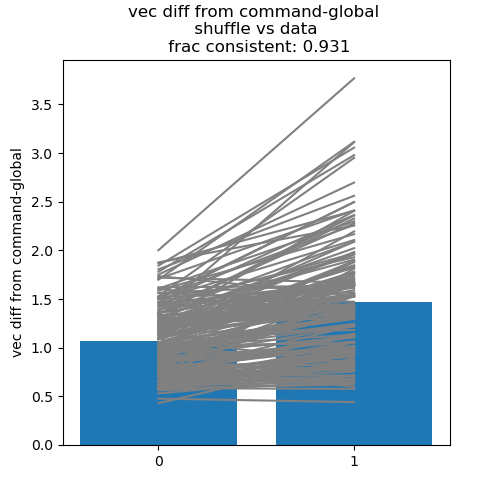

In [38]:
#BAR PLOT: 
fig_name = 'bar_vector_diff_true_vs_shuffle'
save_bool = False

s = np.array(r.loc[:,'shuffle_diff_norm'])
d = np.array(r.loc[:,'true_diff_norm'])
d_plt = np.concatenate((s.reshape(-1,1), d.reshape(-1,1)),axis=1).T

# If you want to see negative vs positive data points:
pos_sel = (d_plt[1,:]-d_plt[0,:])>=0
d_plt_pos = d_plt[:,pos_sel]
neg_sel = (d_plt[1,:]-d_plt[0,:])<0
d_plt_neg = d_plt[:,neg_sel]

frac_consistent = float(sum(pos_sel))/len(d)
#number of data points obeying the trend

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt_pos,color=0.5*np.ones(3))
# _=plt.plot(d_plt_neg,color='r')

_=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])

_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])
plt.ylabel('vec diff from command-global')
plt.title('vec diff from command-global \n shuffle vs data \n frac consistent: ' + str(round(frac_consistent,3)))
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


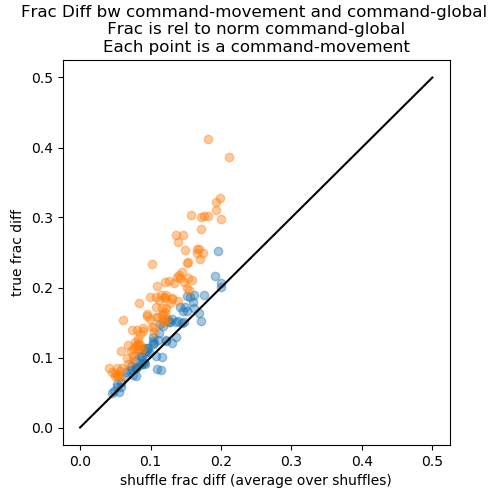

In [39]:
fig_name = 'scatter_vector_frac_diff_true_vs_shuffle'
save_bool = False

# s = r.loc[:,'shuffle_frac_diff_norm']
# d = r.loc[:,'true_frac_diff_norm']

sel = r.loc[:,'sig']==0
s_nsig = r.loc[sel,'shuffle_frac_diff_norm']
d_nsig = r.loc[sel,'true_frac_diff_norm']

sel = r.loc[:,'sig']==1
s_sig = r.loc[sel,'shuffle_frac_diff_norm']
d_sig = r.loc[sel,'true_frac_diff_norm']


plt.figure(figsize=(5,5))
# plt.scatter(s,d,alpha=0.4)
plt.scatter(s_nsig,d_nsig,alpha=0.4, label='not sig')
plt.scatter(s_sig,d_sig,alpha=0.4, label='sig')

plt.plot([0, 0.5], [0,0.5],color='k')
plt.xlabel('shuffle frac diff (average over shuffles)')
plt.ylabel('true frac diff')
plt.title('Frac Diff bw command-movement and command-global \n Frac is rel to norm command-global \nEach point is a command-movement')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


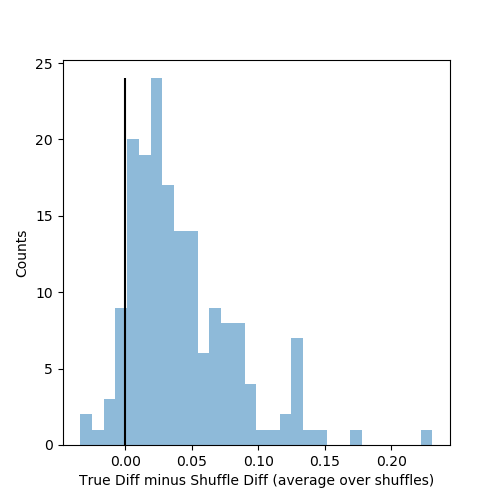

<IPython.core.display.Javascript object>


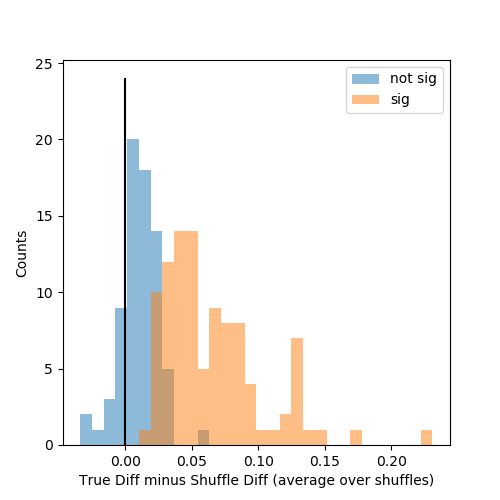

In [40]:
#Histogram of frac differences
#All and just significant: 

#-----------------------------------------------------------------------
fig_name = 'hist_vector_frac_diff_true_minus_shuffle'
save_bool = False

#ALL DATA:
s = r.loc[:,'shuffle_frac_diff_norm']
d = r.loc[:,'true_frac_diff_norm']
diff_df = d-s
diff=list(d-s)
plt.figure(figsize=(5,5))
n_all,bins,_ = plt.hist(diff,bins=30,alpha=0.5)
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


#-----------------------------------------------------------------------
fig_name = 'hist_vector_frac_diff_true_minus_shuffle_sig'
save_bool = False
        
#NOT SIG and SIG:
sel = (r.loc[:,'sig']==0)
s_nsig = r.loc[sel,'shuffle_frac_diff_norm']
d_nsig = r.loc[sel,'true_frac_diff_norm']
diff_nsig=list(d_nsig-s_nsig)

sel = (r.loc[:,'sig']==1)
s_sig = r.loc[sel,'shuffle_frac_diff_norm']
d_sig = r.loc[sel,'true_frac_diff_norm']
diff_sig = list(d_sig-s_sig)

# bin_e = np.linspace(0,4,41)
plt.figure(figsize=(5,5))
# n_all,bins,_ = plt.hist(diff,bins=20,alpha=0.5)
ig = plt.hist(diff_nsig,bins=bins,alpha=0.5,label='not sig')
ig = plt.hist(diff_sig,bins=bins,alpha=0.5,label='sig')
plt.legend()
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


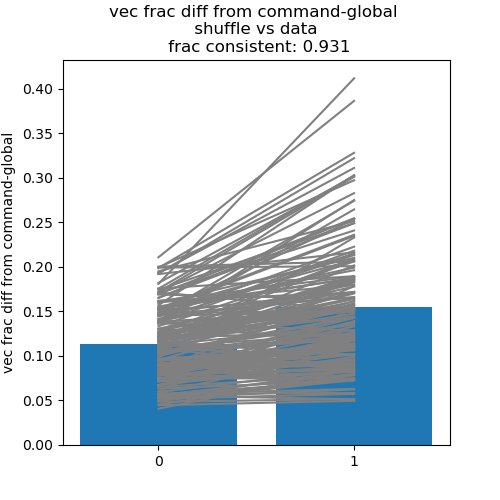

In [41]:
#BAR PLOT: 
fig_name = 'bar_vector_frac_diff_true_vs_shuffle'
save_bool = False

s = np.array(r.loc[:,'shuffle_frac_diff_norm'])
d = np.array(r.loc[:,'true_frac_diff_norm'])
d_plt = np.concatenate((s.reshape(-1,1), d.reshape(-1,1)),axis=1).T

# If you want to see negative vs positive data points:
pos_sel = (d_plt[1,:]-d_plt[0,:])>=0
d_plt_pos = d_plt[:,pos_sel]
neg_sel = (d_plt[1,:]-d_plt[0,:])<0
d_plt_neg = d_plt[:,neg_sel]

frac_consistent = float(sum(pos_sel))/len(d)
#number of data points obeying the trend

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt_pos,color=0.5*np.ones(3))
# _=plt.plot(d_plt_neg,color='r')

_=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])

_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])
plt.ylabel('vec frac diff from command-global')
plt.title('vec frac diff from command-global \n shuffle vs data \n frac consistent: ' + str(round(frac_consistent,3)))
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Using individual neurons:

In [ ]:
#TODO: compute p-value on per neuron basis

In [42]:
cm_dic[c,m,'p_n']

<xarray.DataArray (v: 44)>
array([0.238, 0.642, 0.26 , 0.284, 0.561, 0.056, 0.057, 0.022, 0.733, 0.   ,
       0.028, 0.447, 0.251, 0.649, 0.502, 0.244, 0.288, 0.172, 0.547, 0.3  ,
       0.852, 0.482, 0.97 , 0.597, 0.602, 0.837, 0.466, 0.969, 0.382, 0.204,
       0.2  , 0.185, 0.21 , 0.926, 0.58 , 0.182, 0.198, 0.502, 0.146, 0.636,
       0.203, 0.011, 0.01 , 0.744])
Coordinates:
  * v        (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [ ]:
#Scatter each (neuron,command,movement): true vs shuffle (raw vs diff from global)
#Make a df showing each neuron's activity: 

In [43]:
#histogram the differences of command-movement minus command-mean, for all neurons
#use the matching procedure.
#
# this is analagous to fig3C in jose draft, once we have all the sessions.
#
#Future: could add within movement differences


#Make a dataframe for the results, for each c,m:
#columns: diff, neuron, command_idx, movement_idx, u_v_mag_bin, u_v_angle_bin, task_rot, target
columns = \
[ 'n_c', 'n_cm', 'n_s',\
 'abs_diff', 'frac_abs_diff', 'diff', \
 'abs_diff_s', 'frac_abs_diff_s', 'diff_s', \
 'neuron', 'command_idx', 'movement_idx', \
 'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']
p_sig = 0.05
r = []
for c in c_list:
    for m in cm_dic[c]:
        #Observed:
        n_c_a = np.array(cm_dic[c,m,'n_c'][n_list]).reshape((-1,1))
        n_cm_a = np.array(cm_dic[c,m,'n_cm']).reshape((-1,1))
        n_s_a = np.array(cm_dic[c,m,'n_s'].mean(dim='shuffle')).reshape((-1,1))
        
        diff_n = cm_dic[c,m,'n_diff_true'][n_list]
        abs_diff_a = np.abs(np.array(diff_n)).reshape((-1,1))
        diff_a = np.array(diff_n).reshape((-1,1))
        
        frac_abs_diff_a = abs_diff_a/n_c_a
        
        #Shuffle:
        abs_diff_s = np.abs(cm_dic[c,m,'n_diff_s']).mean(axis=1) #cm_dic[c,m,'n_diff_s'].mean(axis=1)
        diff_s = cm_dic[c,m,'n_diff_s'].mean(axis=1)
        abs_diff_s_a=np.array(abs_diff_s).reshape((-1,1))
        diff_s_a=np.array(diff_s).reshape((-1,1))
        
        frac_abs_diff_s_a = abs_diff_s_a/n_c_a
        
        
        #
        
        
        n_a = np.arange(num_neurons).reshape((-1,1))
        ci_a = (np.ones(num_neurons)*c2idx[c]).reshape((-1,1))
        mi_a = (np.ones(num_neurons)*m2idx[m]).reshape((-1,1))
        mag_a = (np.ones(num_neurons)*c[0]).reshape((-1,1))
        angle_a = (np.ones(num_neurons)*c[1]).reshape((-1,1))
        
        p_a = np.array(cm_dic[c,m,'p_n']).reshape((-1,1))
        sig_a = p_a<=p_sig
#         sig_a = ((cm_dic[c,m,'p']<=p_sig)*np.ones(num_neurons)).reshape((-1,1))
        
#         print(m)
        target_a = (np.ones(num_neurons)*m[0]).reshape((-1,1))
        task_a = (np.ones(num_neurons)*m[1]).reshape((-1,1))
        
        diff_a = np.concatenate((n_c_a, n_cm_a, n_s_a, \
                                 abs_diff_a, frac_abs_diff_a, diff_a,\
                                 abs_diff_s_a, frac_abs_diff_s_a, diff_s_a,\
                                 n_a, ci_a, mi_a, mag_a, angle_a, target_a, task_a, p_a, sig_a),axis=1)
        diff_df = pd.DataFrame(diff_a, columns=columns)
        
        r.append(diff_df)

r = pd.concat(r,ignore_index=True)

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in divide


<IPython.core.display.Javascript object>


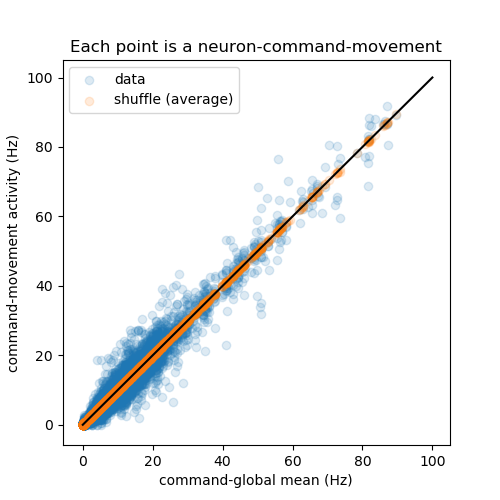

In [44]:
#Scatter: True vs Shuffle vs Global: 

fig_name = 'n_scatter_true_vs_shuffle_vs_global'
save_bool = False

sample_period=0.1
#ALL:
d = r.loc[:,'n_cm']/sample_period
s = r.loc[:,'n_s']/sample_period
g = r.loc[:,'n_c']/sample_period


plt.figure(figsize=(5,5))
plt.scatter(g,d,alpha=0.15, label='data')
plt.scatter(g,s,alpha=0.15, label='shuffle (average)')
plt.legend()

plt.plot([0, 100], [0,100],color='k')
plt.xlabel('command-global mean (Hz)')
plt.ylabel('command-movement activity (Hz)')
plt.title('Each point is a neuron-command-movement')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


<IPython.core.display.Javascript object>


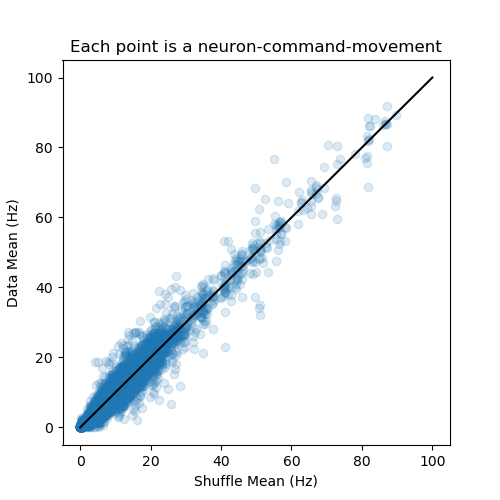

In [45]:
#Scatter: True vs Shuffle: 

fig_name = 'n_scatter_true_vs_shuffle'
save_bool = False

sample_period=0.1
#ALL:
d = r.loc[:,'n_cm']/sample_period
s = r.loc[:,'n_s']/sample_period


plt.figure(figsize=(5,5))
plt.scatter(s,d,alpha=0.15)

plt.plot([0, 100], [0,100],color='k')
plt.xlabel('Shuffle Mean (Hz)')
plt.ylabel('Data Mean (Hz)')
plt.title('Each point is a neuron-command-movement')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


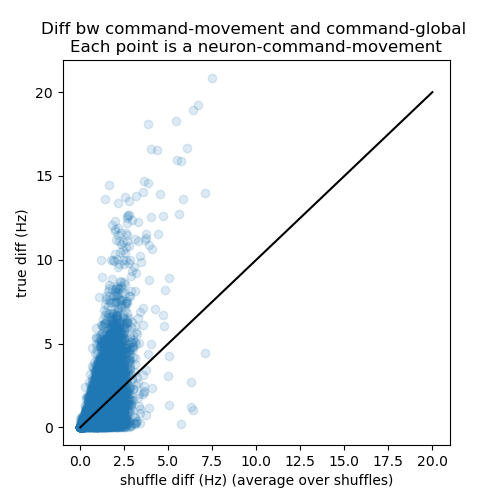

In [46]:
#Scatter Diff: True vs Shuffle: 

fig_name = 'n_diff_scatter_true_vs_shuffle'
save_bool = False

sample_period=0.1
#ALL:
d = r.loc[:,'abs_diff']/sample_period
s = r.loc[:,'abs_diff_s']/sample_period


plt.figure(figsize=(5,5))
plt.scatter(s,d,alpha=0.15)
plt.plot([0, 20], [0,20],color='k')
plt.xlabel('shuffle diff (Hz) (average over shuffles)')
plt.ylabel('true diff (Hz)')
plt.title('Diff bw command-movement and command-global \nEach point is a neuron-command-movement')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

#SIG:


<IPython.core.display.Javascript object>


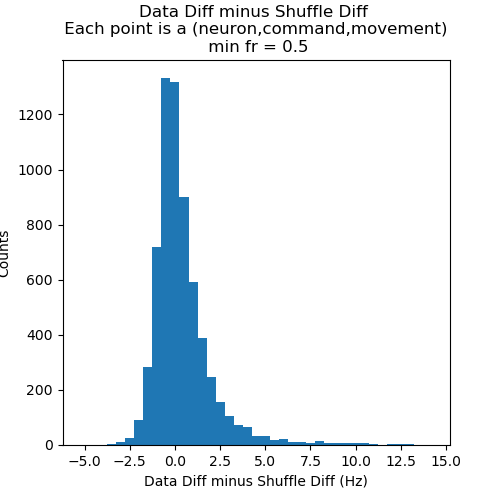

In [48]:
#Histogram the differences: 
fig_name='n_hist_data_diff_minus_shuffle_diff'
save_bool = False


sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
# sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr#&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

diff = d-s

bin_width=0.5
bin_e = np.arange(-5,15,bin_width)-bin_width/2
plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff, bin_e)
# plt.vlines(0,0,1.05*n.max())
plt.xlabel('Data Diff minus Shuffle Diff (Hz)')
plt.ylabel('Counts')
plt.title('Data Diff minus Shuffle Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
    

<IPython.core.display.Javascript object>


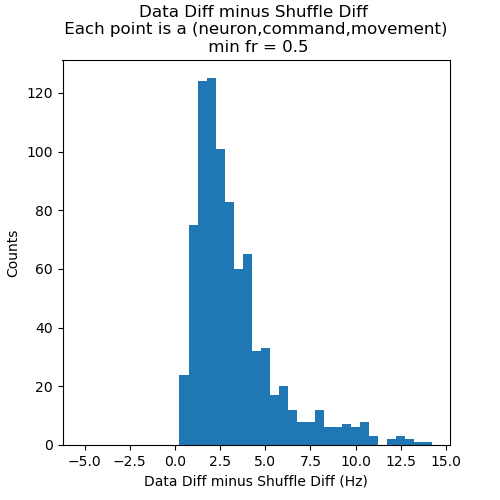

In [49]:
#Histogram the differences: 
fig_name='n_hist_data_diff_minus_shuffle_diff_SIG'
save_bool = False


sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

diff = d-s

bin_width=0.5
bin_e = np.arange(-5,15,bin_width)-bin_width/2
plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff, bin_e)
# plt.vlines(0,0,1.05*n.max())
plt.xlabel('Data Diff minus Shuffle Diff (Hz)')
plt.ylabel('Counts')
plt.title('Data Diff minus Shuffle Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
    

<IPython.core.display.Javascript object>


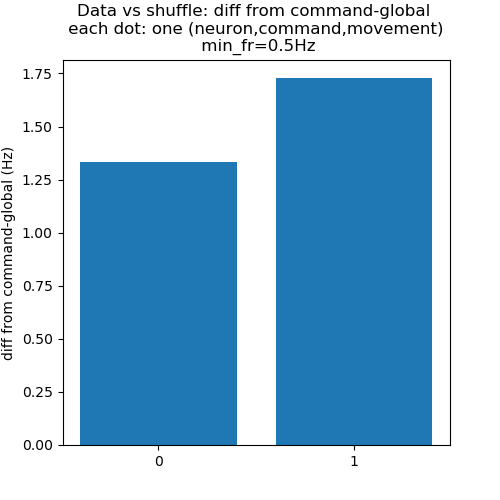

In [50]:
#Bar plot: 
#ALL

#Histogram the differences: 
fig_name='n_bar_data_diff_vs_shuffle_diff'
save_bool = False

sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
# sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr#&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

d_a = np.array(d)
s_a = np.array(s)
d_plt = np.concatenate((s_a.reshape(-1,1), d_a.reshape(-1,1)),axis=1).T

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])
plt.title('Data vs shuffle: diff from command-global \n each dot: one (neuron,command,movement) \n min_fr=0.5Hz')
_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])


plt.ylabel('diff from command-global (Hz)')
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


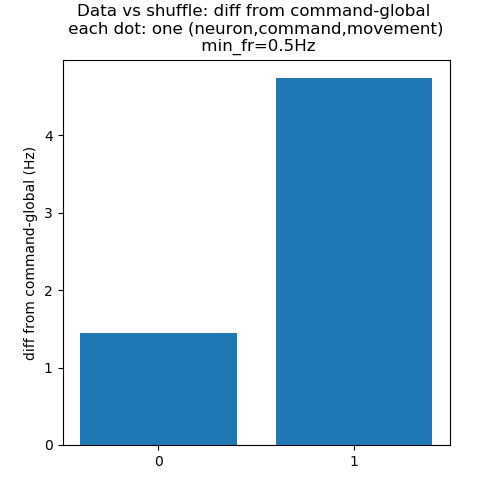

In [51]:
#Bar plot: 
#ALL

#Histogram the differences: 

save_bool = False
no_lines = True
if no_lines:
    fig_name='n_bar_data_diff_vs_shuffle_diff_SIG_no_lines'
else:
    fig_name='n_bar_data_diff_vs_shuffle_diff_SIG'



sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

d_a = np.array(d)
s_a = np.array(s)
d_plt = np.concatenate((s_a.reshape(-1,1), d_a.reshape(-1,1)),axis=1).T

plt.figure(figsize=(5,5))

if not no_lines:
    _=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])
plt.title('Data vs shuffle: diff from command-global \n each dot: one (neuron,command,movement) \n min_fr=0.5Hz')
_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])


plt.ylabel('diff from command-global (Hz)')
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Individual neuron Frac Diff

<IPython.core.display.Javascript object>


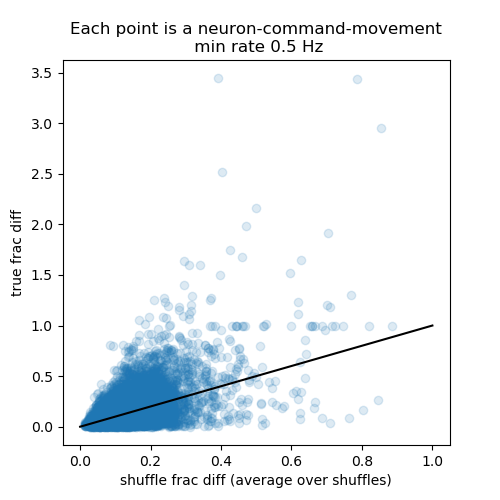

In [52]:
#Scatter Frac Diff: True vs Shuffle
#This doesn't look good for neurons with low mean rates:

fig_name = 'n_frac_diff_scatter_true_vs_shuffle'
save_bool = False

sample_period=0.1
#ALL:
min_fr = 0.5
sel = (r.loc[:,'n_c']/sample_period >= min_fr)
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']


plt.figure(figsize=(5,5))
plt.scatter(s,d,alpha=0.15)
plt.plot([0, 1.], [0,1],color='k')
plt.xlabel('shuffle frac diff (average over shuffles)')
plt.ylabel('true frac diff')
plt.title('Each point is a neuron-command-movement\n min rate 0.5 Hz')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

#SIG:

<IPython.core.display.Javascript object>


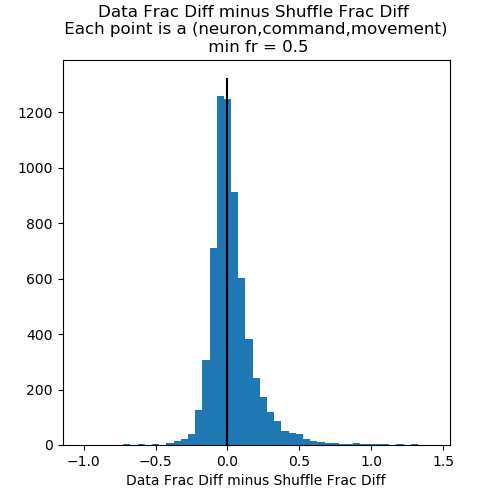

In [53]:
#Histogram of differences in frac diff: 
fig_name='n_hist_data_frac_diff_minus_shuffle_diff'
save_bool = False

sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
# sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr#&sel_sig
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']
# d = r.loc[sel,'abs_diff']/sample_period
# s = r.loc[sel,'abs_diff_s']/sample_period
diff = d-s

bin_width=0.05
bin_e = np.arange(-1,1.5,bin_width)-bin_width/2

plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff, bin_e)
plt.vlines(0,0,1.05*n.max())
plt.xlabel('Data Frac Diff minus Shuffle Frac Diff')
# plt.ylabel('Counts')
plt.title('Data Frac Diff minus Shuffle Frac Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))


<IPython.core.display.Javascript object>


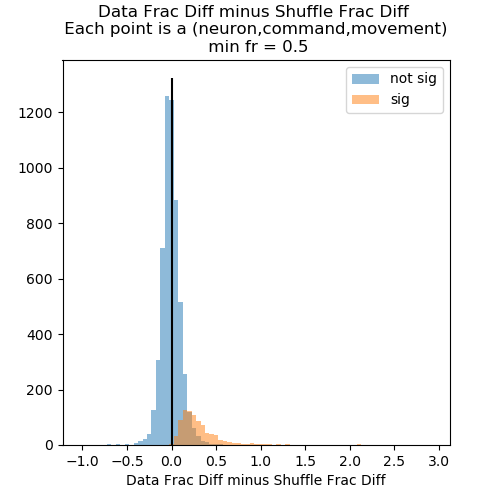

In [54]:
#Histogram of differences in frac diff: 
fig_name='n_hist_data_frac_diff_minus_shuffle_diff_SIG'
save_bool = False


sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)


sel = sel_min_fr&sel_sig
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']
diff_sig = d-s

sel = sel_min_fr&(~sel_sig)
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']
diff_not_sig = d-s



bin_width=0.05
bin_e = np.arange(-1,3,bin_width)-bin_width/2
plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff_not_sig, bin_e,alpha=0.5,label='not sig')
n_max = n.max()
n,_,_=plt.hist(diff_sig, bin_e,alpha=0.5,label='sig')
n_max = np.array([n_max, n.max()]).max()
plt.vlines(0,0,1.05*n_max)
plt.xlabel('Data Frac Diff minus Shuffle Frac Diff')
# plt.ylabel('Counts')
plt.title('Data Frac Diff minus Shuffle Frac Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')
plt.legend()

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))


n_bar_frac_diff_data_vs_shuffle_SIG_no_lines


<IPython.core.display.Javascript object>


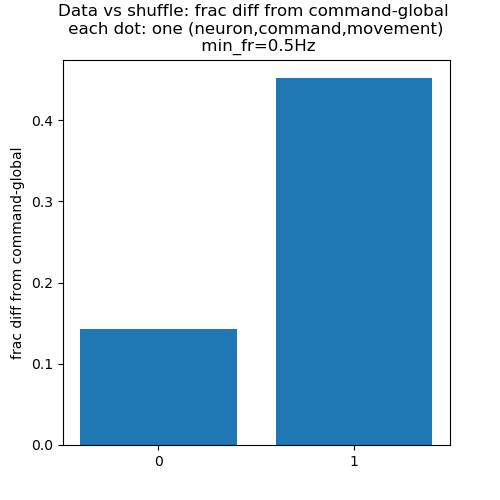

In [55]:
#BAR PLOT: 

save_bool = False
sig = True
no_lines = True
fig_name = 'n_bar_frac_diff_data_vs_shuffle'
if sig: 
    fig_name += '_SIG'
if no_lines:
    fig_name += '_no_lines'
print(fig_name)

sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)

if sig:
    sel = sel_min_fr&sel_sig
else:
    sel = sel_min_fr

d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']

d_a = np.array(d)
s_a = np.array(s)
d_plt = np.concatenate((s_a.reshape(-1,1), d_a.reshape(-1,1)),axis=1).T

plt.figure(figsize=(5,5))

if not no_lines:
    _=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])
plt.title('Data vs shuffle: frac diff from command-global \n each dot: one (neuron,command,movement) \n min_fr=0.5Hz')
_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])


plt.ylabel('frac diff from command-global')
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


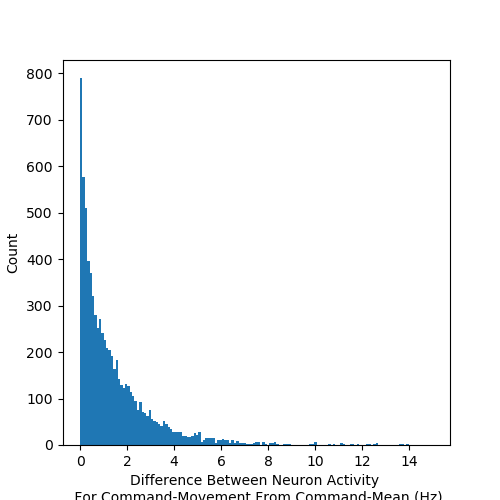

In [56]:
fig_name = 'hist_neuron_diff'
save_bool = False

bmi_sample_period = 0.1 #sec
bin_e = np.linspace(0,15,num=15*10,endpoint=True)

d = r.loc[:,'abs_diff']/bmi_sample_period
plt.figure(figsize=(5,5))
plt.hist(d, bins=bin_e)
plt.xlabel('Difference Between Neuron Activity \n For Command-Movement From Command-Mean (Hz)')
plt.ylabel('Count')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


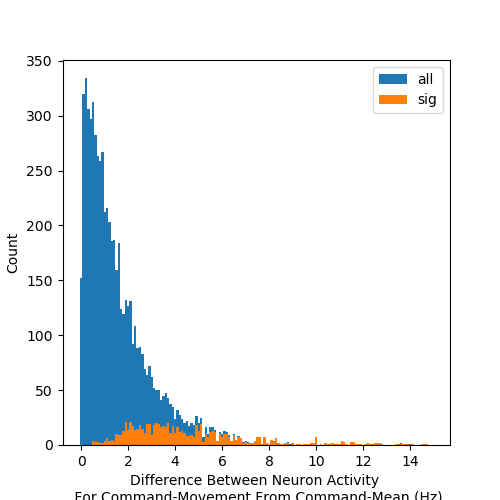

In [57]:
fig_name = 'hist_neuron_diff_all_vs_sig'
save_bool = False

sel_min_fr_ = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig_ = (r.loc[:,'sig']==1)

sel_all = sel_min_fr_
sel_sig = sel_min_fr_ & sel_sig_


d = r.loc[sel_all,'abs_diff']/bmi_sample_period
w_d = 1.0/len(d)*np.ones(len(d))

sig_sel = r.loc[:,'sig']==1
d_sig = r.loc[sel_sig,'abs_diff']/bmi_sample_period
w_d_sig = 1.0/len(d_sig)*np.ones(len(d_sig))


bmi_sample_period = 0.1 #sec
bin_e = np.linspace(0,15,num=15*10+1,endpoint=True)-0.05

plt.figure(figsize=(5,5))
plt.hist(d, bins=bin_e, label='all')
plt.hist(d_sig, bins=bin_e, label='sig') #alpha, weights



plt.legend()
plt.xlabel('Difference Between Neuron Activity \n For Command-Movement From Command-Mean (Hz)')
plt.ylabel('Count')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


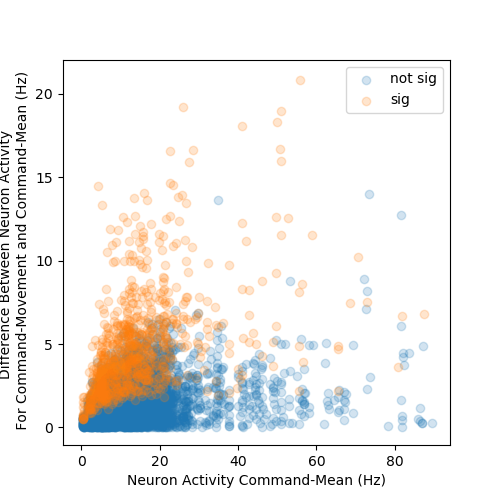

In [58]:
#Scatter command_mean vs diff

fig_name = 'scatter_neuron_command_mean_vs_diff'
save_bool = False
bin_sample_period = 0.1
alpha = 0.2

plt.figure(figsize=(5,5))

#not sig:
sel = sel_min_fr_&(~sel_sig_)
d_cm = r.loc[sel,'n_c']/bmi_sample_period
d_diff = r.loc[sel,'abs_diff']/bmi_sample_period
plt.scatter(d_cm, d_diff,alpha=alpha,label='not sig')

#sig:
sel_min_fr_ = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig_ = (r.loc[:,'sig']==1)

sel = sel_min_fr_&sel_sig_
d_cm = r.loc[sel,'n_c']/bmi_sample_period
d_diff = r.loc[sel,'abs_diff']/bmi_sample_period

plt.scatter(d_cm, d_diff,alpha=alpha,label='sig')




plt.xlabel('Neuron Activity Command-Mean (Hz)')
plt.ylabel('Difference Between Neuron Activity \n For Command-Movement and Command-Mean (Hz)')
plt.legend()

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Plots for example command, all neurons

In [15]:
#This example was found in:
# 'neural_mean_diff_rel_shuffle_corr_behavior_dynamics_conditioning'

c = (0,2)
m_analyze = cm_dic[c] #[(0, 1.1), (1, 0), (1, 1.1), (2, 0), (2, 1.1), (3, 1.1), (4, 1.1)]
num_m_analyze = len(m_analyze)
m = m_analyze[0]
# cm_dic[c,m,]

num_samples_m = []
for m in m_analyze:
    num_i = len(np.where(cm_dic[c,m,'sel'])[0])
    num_samples_m.append(num_i)
print(num_samples_m)

[40, 26, 62, 27, 61, 15, 92, 60, 24]


### parameters for z-scoring 

In [ ]:
#analysis requires:
#command_mean
#command_movement_mean
#shuffle_mean

In [16]:
#Calc mean and std for z-scoring, as df and np array:
#Calculate the mean and sigma of each neuron, pooling all data: 
#np.cov: row: var, col: obs
bmi_sample_period = 0.1

zscore_global = True
zscore_command = False

if zscore_global:
    n_df = df.loc[:,n_list]/bmi_sample_period
elif zscore_command:
    sel = cm_dic[c,'sel']
    n_df = df.loc[sel,n_list]/bmi_sample_period
else:
    print('PICK A zscore option')
n_cov = np.cov(n_df.T)
n_var = np.diag(n_cov)
n_std = n_var**(0.5)
n_mean = n_df.mean()

#ASSIGN:
n_std_a = np.array(n_std).reshape((-1,1))
n_std_df = pd.DataFrame(data=n_std_a.reshape(1,-1), columns=n_list)

n_mean_a = np.array(n_mean).reshape((-1,1))
n_mean_df = pd.DataFrame(data=n_mean_a.reshape(1,-1), columns=n_list)


### inspect

In [78]:
n_mean_df

n_0       n_1       n_2       n_3        n_4        n_5        n_6  \
0  12.255062  4.695611  0.208588  0.317299  11.911265  22.350183  13.558228   

        n_7       n_8      n_9  ...      n_34      n_35       n_36       n_37  \
0  2.564887  0.169181  0.10871  ...  3.683924  8.861938  29.137111  23.115912   

        n_38       n_39       n_40       n_41      n_42       n_43  
0  38.969969  10.402908  16.584454  26.246093  7.017937  13.401957  

[1 rows x 44 columns]

In [79]:
n_std_df

n_0       n_1       n_2       n_3       n_4       n_5        n_6  \
0  12.134035  6.822308  1.457412  1.779788  11.52011  15.37687  11.812548   

        n_7       n_8       n_9  ...      n_34       n_35       n_36  \
0  5.069843  1.289689  1.050018  ...  6.394951  10.241487  23.206096   

        n_37      n_38       n_39       n_40       n_41      n_42       n_43  
0  19.900726  29.15748  11.699711  14.897445  33.336874  12.97186  14.193367  

[1 rows x 44 columns]

In [83]:
n_mean_df

n_0       n_1      n_2       n_3      n_4        n_5   n_6       n_7  \
0  10.261194  4.216418  0.11194  0.298507  9.88806  20.932836  12.5  2.350746   

        n_8       n_9  ...      n_34      n_35       n_36       n_37  \
0  0.186567  0.223881  ...  2.798507  5.671642  21.231343  16.604478   

        n_38     n_39       n_40       n_41      n_42      n_43  
0  27.089552  6.19403  20.783582  11.119403  6.567164  9.925373  

[1 rows x 44 columns]

In [84]:
n_std_df

n_0       n_1       n_2       n_3        n_4        n_5        n_6  \
0  11.848247  6.458003  1.054048  1.704938  10.367163  14.465093  10.426306   

        n_7       n_8       n_9  ...      n_34      n_35       n_36  \
0  4.747966  1.355626  1.482188  ...  5.335599  7.338551  12.466233   

        n_37       n_38      n_39     n_40       n_41       n_42       n_43  
0  11.186213  10.693176  7.960085  9.70259  16.059834  11.521319  11.284291  

[1 rows x 44 columns]

<IPython.core.display.Javascript object>


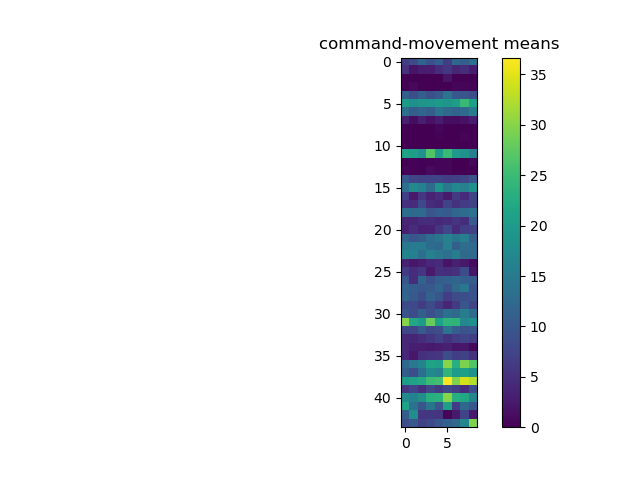

<IPython.core.display.Javascript object>


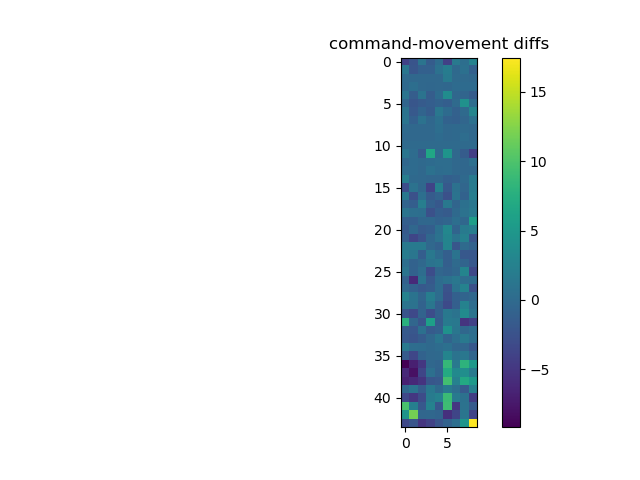

Text(0.5,1,'command-movement diffs')

In [17]:
#command_mean, command_movement_mean, diff: 

#command_mean: 
nc_mat = df.loc[cm_dic[c,'sel'], n_list]
n_c = nc_mat.mean(axis=0)/bmi_sample_period

#command_movement_mean:
#make a matrix of size: num_neurons X num_movements, which has the mean activity of each neuron
bmi_sample_period = 0.1
n_mat = np.zeros((num_neurons, num_m_analyze))
for i,m in enumerate(m_analyze): 
    n_mat[:,i] = cm_dic[c,m,'n_cm']
n_mat = n_mat/bmi_sample_period
plt.figure()
plt.imshow(n_mat)
plt.colorbar()
plt.title('command-movement means')

#ASSIGN:
n_c_a = np.array(n_c).reshape((-1,1))
n_cm_a = np.array(n_mat)

n_c_df = pd.DataFrame(data=n_c_a.reshape(1,-1), columns=n_list)
n_cm_da =  xr.DataArray(data=n_cm_a, coords={'neuron':np.arange(num_neurons), 'movement':np.arange(num_m_analyze)}, dims=['neuron', 'movement'])


#command_movement_diff: 
diff_a = n_cm_a-n_c_a #np.array(n_mat)-n_c_a
diff_da = n_cm_da-n_c_a

plt.figure()
plt.imshow(diff_a)
plt.colorbar()
plt.title('command-movement diffs')

<IPython.core.display.Javascript object>


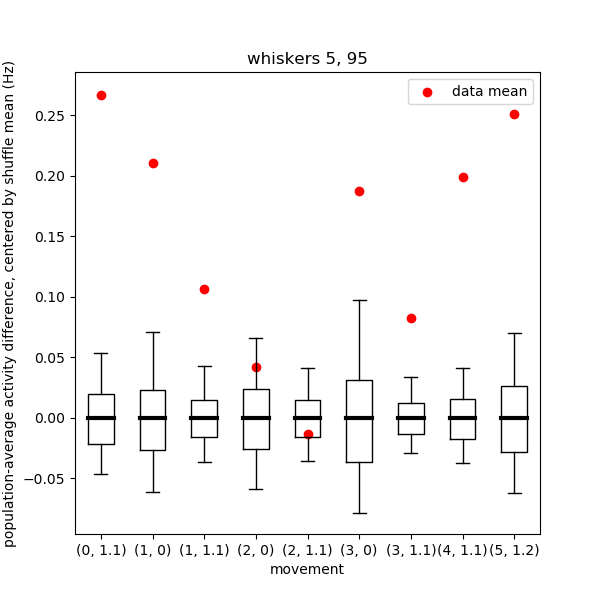

In [19]:
#data that is accessed: 
#n_c_a
#n_mean_aa
#n_std_a
#diff_a
#

save_bool = True
fig_name = 'ex_shuffle_npop_c_over_m_boxplot_L2_avg_alltrial'

norm_ord = 2
shuffle_center = True
zscore_bool = False
choose_valid = False
min_fr = 0.5

if shuffle_center:
    fig_name += '_shuffleC'
if zscore_bool:
    fig_name += '_Z'
if choose_valid:
    figname +='_validN'

if choose_valid:
    ni = np.where(n_mean_a>=min_fr )[0]
else:
    ni  = np.arange(num_neurons)

if shuffle_center:
    ylabel_str = 'population-average activity difference, centered by shuffle mean'
else:
    ylabel_str = 'population-average activity difference'

if zscore_bool: 
    ylabel_str += ': zscore (sigma)'
else:
    ylabel_str += ' (Hz)'
    
    
n_label = n_list


if zscore_bool:
    n_c = copy.copy((n_c_a[ni,:]-n_mean_a[ni,:])/n_std_a[ni,:])
    diff = copy.copy(diff_a[ni,:]/n_std_a[ni,:]) #since it's a diff, don't need to subtract the means
else:
    n_c = copy.copy(n_c_a[ni,:])
    diff = copy.copy(diff_a[ni,:])
      
d_diff = np.linalg.norm(diff, ord=norm_ord, axis=0)/num_neurons
d_diff_plt = copy.copy(d_diff)


s_list = []
for i,m in enumerate(m_analyze):
    s = np.array(cm_dic[c,m,'n_s'].loc[n_label,:])
    s = s[ni,:]
    s = s/bmi_sample_period
    if zscore_bool:
        s = (s-n_mean_a[ni,:])/n_std_a[ni,:]
        
    diff = np.linalg.norm(s-n_c, axis=0, ord=norm_ord)/num_neurons
    if shuffle_center:
        diff_plt = diff-diff.mean()
        d_diff_plt[i] -= diff.mean()
    else:
        diff_plt = diff
    
    s_list.append(diff_plt)
    
    
medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')

whis=[5,95]
fig,ax=plt.subplots(figsize=(6,6))
_=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True

x_plt = np.arange(len(d_diff_plt))+1
plt.scatter(x_plt, d_diff_plt, color='r', label='data mean')

plt.xticks(x_plt, m_analyze)
plt.xlabel('movement')
plt.ylabel(ylabel_str)
plt.title('whiskers 5, 95')
plt.legend()

if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir,fig_name+ext))



### Implement frac diff:

In [39]:
#choose neurons with high enough fr
min_fr = 0.5
n_valid = np.where(n_c>=min_fr)[0]
n_label_valid = ['n_' + str(i) for i in n_valid]
print(n_label_valid)
num_n_valid = len(n_valid)
n_c_valid = n_c_df.loc[:,n_label_valid]
n_c_valid = np.array(n_c_valid).reshape((1,-1))

['n_0', 'n_1', 'n_4', 'n_5', 'n_6', 'n_7', 'n_11', 'n_14', 'n_15', 'n_16', 'n_17', 'n_18', 'n_19', 'n_20', 'n_21', 'n_22', 'n_23', 'n_24', 'n_25', 'n_26', 'n_27', 'n_28', 'n_29', 'n_30', 'n_31', 'n_32', 'n_33', 'n_34', 'n_35', 'n_36', 'n_37', 'n_38', 'n_39', 'n_40', 'n_41', 'n_42', 'n_43']


In [76]:
#Data diffs: 
n_c_a =  np.array(n_c_df.loc[:,n_label_valid]).reshape((-1,1))
n_mat_v = np.array(n_mat[n_valid,:])
diff = n_mat_v-n_c_a

#-----------------------------------------------------------------------------------------------
d_diff = np.linalg.norm(diff, ord=1, axis=0)

#-----------------------------------------------------------------------------------------------
confirm = np.sum(np.abs(diff),axis=0)/num_n_valid

#this doesn't work until you remove low fr neurons: 
frac_diff = diff/n_c_a
#-----------------------------------------------------------------------------------------------
d_frac_diff = np.linalg.norm(frac_diff, ord=1, axis=0)
d_frac_diff = d_frac_diff/num_n_valid
#-----------------------------------------------------------------------------------------------


# print(d_diff)
# print(confirm)

plot_bool = False
if plot_bool:
    print(d_frac_diff)

    plt.figure()
    plt.imshow(n_mat_v)
    plt.colorbar()
    plt.title('fr')
    plt.xlabel('movement')
    plt.ylabel('valid neurons')

    plt.figure()
    plt.imshow(diff)
    plt.colorbar()
    plt.title('fr diff')
    plt.xlabel('movement')
    plt.ylabel('valid neurons')

    plt.figure()
    plt.imshow(frac_diff)
    plt.colorbar()
    plt.title('frac diff')
    plt.xlabel('movement')
    plt.ylabel('valid neurons')

<IPython.core.display.Javascript object>


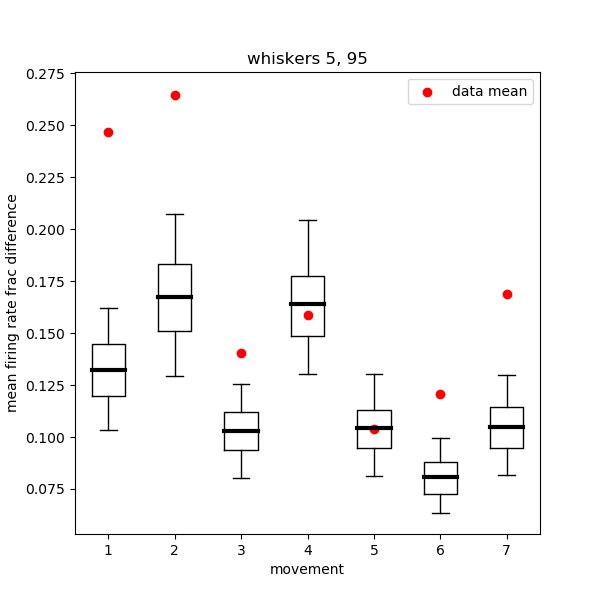

In [43]:
frac_bool = True
if frac_bool:
    d = d_frac_diff
    y_label_str = 'mean firing rate frac difference'    
else:
    d = d_diff
    y_label_str = 'mean firing rate difference (Hz)'

n_c_a =  np.array(n_c_df.loc[:,n_label_valid]).reshape((-1,1))

s_list = []
for m in m_analyze:
    s = np.array(cm_dic[c,m,'n_s'].loc[n_label_valid,:])
    s = s/bmi_sample_period
    vec_diff = s-n_c_a
    
    if frac_bool:
        vec_frac_diff = vec_diff/n_c_a
        diff = np.linalg.norm(vec_frac_diff, axis=0, ord=1)/num_n_valid
    else:
        diff = np.linalg.norm(vec_diff, axis=0, ord=1)/num_n_valid
    s_list.append(diff)
    
medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')

whis=[5,95]
fig,ax=plt.subplots(figsize=(6,6))
_=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True

plt.scatter(np.arange(7)+1, d, color='r', label='data mean')

plt.xlabel('movement')
plt.ylabel(y_label_str)
plt.title('whiskers 5, 95')
plt.legend()

### Plots for example command, neuron

In [20]:
#This example was found in:
# 'neural_mean_diff_rel_shuffle_corr_behavior_dynamics_conditioning'

c = (0,2)
m_analyze = cm_dic[c] #[(0, 1.1), (1, 0), (1, 1.1), (2, 0), (2, 1.1), (3, 1.1), (4, 1.1)]
num_m_analyze = len(m_analyze)
m = m_analyze[0]
# cm_dic[c,m,]

<IPython.core.display.Javascript object>


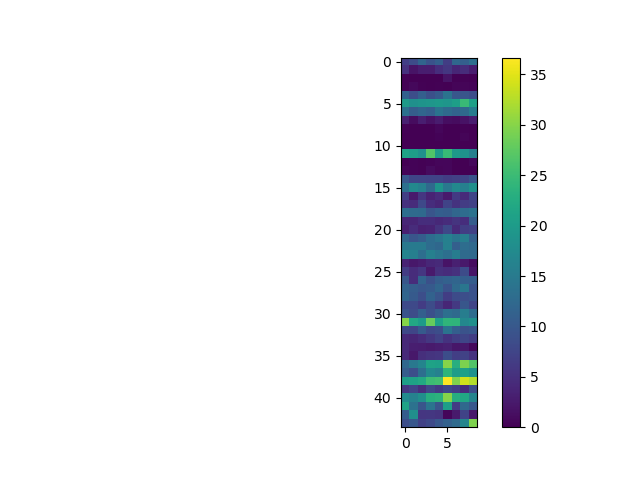

In [21]:
#global_mean: 
nc_mat = df.loc[cm_dic[c,'sel'], n_list]
n_c = nc_mat.mean(axis=0)/bmi_sample_period

#mean for each movement:
#make a matrix of size: num_neurons X num_movements, which has the mean activity of each neuron
bmi_sample_period = 0.1
n_mat = np.zeros((num_neurons, num_m_analyze))
for i,m in enumerate(m_analyze): 
    n_mat[:,i] = cm_dic[c,m,'n_cm']
n_mat = n_mat/bmi_sample_period
plt.figure()
plt.imshow(n_mat)
plt.colorbar()

In [22]:
#global_mean: 
nc_mat = df.loc[cm_dic[c,'sel'], n_list]
n_c = nc_mat.mean(axis=0)/bmi_sample_period

<IPython.core.display.Javascript object>


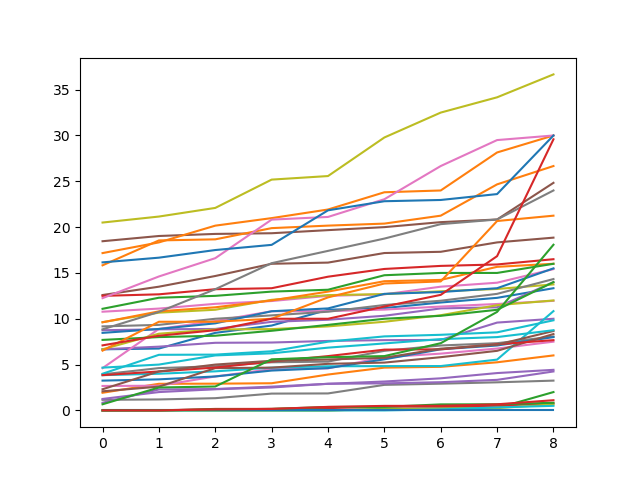

array([10,  9,  8,  3, 12, 13,  2,  7, 24, 14, 34, 33, 23,  1, 39, 18, 17,
        6, 20, 16, 22, 27,  4, 28, 29, 25, 15, 32, 35,  5, 21,  0, 19, 30,
       26, 11, 31, 40, 41, 37, 38, 42, 36, 43], dtype=int64)

In [23]:
#just for visualization: 
ex_diff = []
ex_min = []
ex_max = []
plt.figure()
for i in range(num_neurons):
    y = n_mat[i,:]
    y = np.sort(y)
    plt.plot(y)
    
    ex_diff.append(y.max()-y.min())
    ex_min.append(y.min())
    ex_max.append(y.max())
ex_diff = np.array(ex_diff)    
ex_min = np.array(ex_min)    
ex_max = np.array(ex_max)    
np.argsort(ex_diff)

<IPython.core.display.Javascript object>


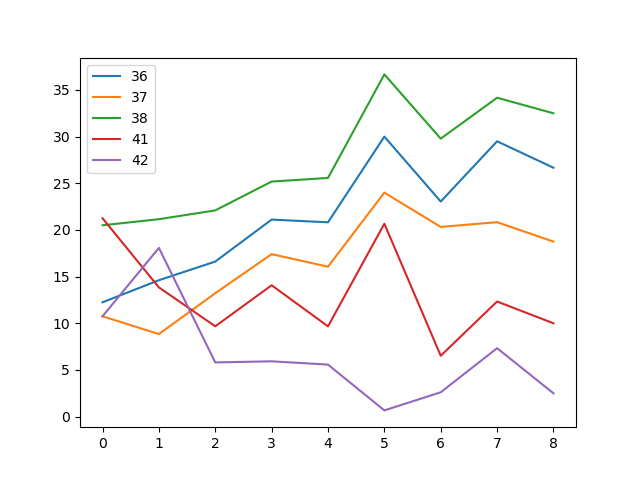

In [24]:
plot_list = [36,37,38,41,42]
plt.figure()
for i in plot_list:
    y = n_mat[i,:]
#     ys = np.sort(y)
    plt.plot(y, label=i)
plt.legend()

<IPython.core.display.Javascript object>


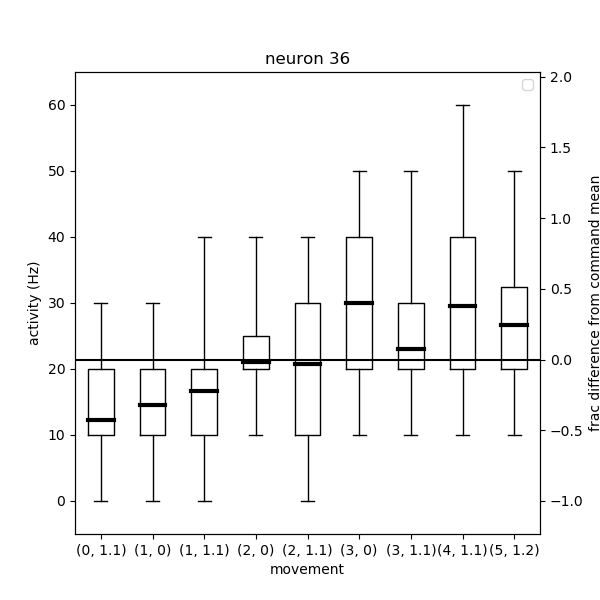

In [25]:
n_sel = 36
fig_name = 'ex_n_c_over_m_boxplot_n'+str(n_sel)+'_alltrial'
save_bool = True

fr_ylim = np.array([-5,65])

n_label = n_list[n_sel]
d_list = []
for m in m_analyze:
    d = np.array(cm_dic[c,m,'mat_df'].loc[:,n_label])
    d = d/bmi_sample_period
    d_list.append(d)

medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')
# plt.figure(figsize=(5,5))
fig,ax=plt.subplots(figsize=(6,6))
_=plt.boxplot(d_list,whis=[2.5,97.5], meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True

y=n_mat[n_sel,:]
# plt.plot(np.arange(num_m_analyze)+1, y, label='mean')
plt.hlines(n_c[n_sel],0,len(d_list)+1,label='command mean')


plt.xlabel('movement')
plt.xticks(x_plt, m_analyze)
plt.title('neuron ' + str(n_sel))
ax.set_ylabel('activity (Hz)')
ax2 = ax.twinx()
ax2.set_ylabel('frac difference from command mean')

ax.set_ylim(fr_ylim)
frac_ylim = (fr_ylim-n_c[n_sel])/(n_c[n_sel])
ax2.set_ylim(frac_ylim)
    
    
plt.legend()



if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
        

In [ ]:
#Now we want the shuffle distributions for each.
#The shuffle means may not match the command mean

<IPython.core.display.Javascript object>


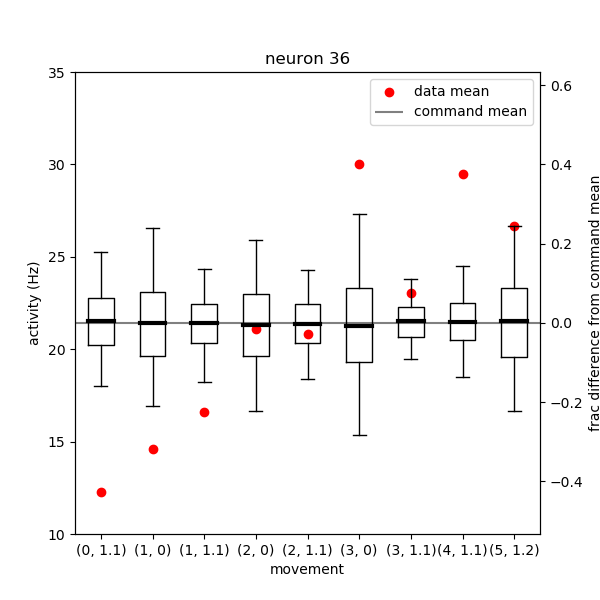

In [26]:
n_sel = 36
save_bool = True
fig_name = 'ex_shuffle_n_c_over_m_boxplot_n'+str(n_sel) + '_alltrial'
fr_ylim = np.array([10,35])

frac_bool = False
if not frac_bool:
    n_c_plt = n_c[n_sel]
    ncm = n_mat[n_sel,:]
else:
    fig_name += '_frac'
    n_c_plt = 0
    ncm = (n_mat[n_sel,:]-n_c[n_sel])/n_c[n_sel]
    


n_label = n_list[n_sel]
s_list = []
for m in m_analyze:
    s = np.array(cm_dic[c,m,'n_s'].loc[n_label,:])
    s = s/bmi_sample_period
    if frac_bool:
        s = (s-n_c[n_sel])/n_c[n_sel]
    s_list.append(s)
    
medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')

fig,ax=plt.subplots(figsize=(6,6))
_=plt.boxplot(s_list,whis=[2.5,97.5], meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True


#Scatter the mean of the true data: 
n_mat = np.zeros((num_neurons, num_m_analyze))
for i,m in enumerate(m_analyze): 
    n_mat[:,i] = cm_dic[c,m,'n_cm']
n_mat = n_mat/bmi_sample_period

x_plt = np.arange(len(s_list))+1
plt.scatter(x_plt, ncm, color='r', label='data mean')

#command mean: 
plt.hlines(n_c_plt,0,len(s_list)+1,label='command mean',color=0.5*np.ones(3))

plt.xlabel('movement')
plt.xticks(x_plt, m_analyze)
plt.title('neuron ' + str(n_sel))
plt.legend()

if not frac_bool:
    ax.set_ylabel('activity (Hz)')
    ax2 = ax.twinx()
    ax2.set_ylabel('frac difference from command mean')

    ax.set_ylim(fr_ylim)
    frac_ylim = (fr_ylim-n_c[n_sel])/(n_c[n_sel])
    ax2.set_ylim(frac_ylim)

if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
        


In [90]:
x_plt

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
ncm

array([ 9.47368421, 12.94117647, 15.85365854, 22.        , 20.21276596,
       23.56164384, 30.        ])

In [32]:
m_analyze

[(0, 1.1), (1, 0), (1, 1.1), (2, 0), (2, 1.1), (3, 1.1), (4, 1.1)]

In [34]:
obs_m = [cm_dic[c,m_i,'num_obs'] for m_i in m_analyze]
print(obs_m)

[19, 17, 41, 20, 47, 73, 51]


In [51]:
obs_m = [cm_dic[c,m_i,'num_obs'] for m_i in m_analyze]
print(obs_m)

[40, 26, 62, 27, 61, 92, 60]


In [93]:
m_analyze

[(0, 1.1),
 (1, 0),
 (1, 1.1),
 (2, 0),
 (2, 1.1),
 (3, 0),
 (3, 1.1),
 (4, 1.1),
 (5, 1.2)]

In [94]:
obs_m = [cm_dic[c,m_i,'num_obs'] for m_i in m_analyze]
print(obs_m)

[40, 26, 62, 27, 61, 15, 92, 60, 24]


In [52]:
#check how much subsampling happened for each of these
num_pool_samples = len(np.where(cm_dic[c,'sel'])[0])
print('num pool samples:', num_pool_samples)
for m in m_analyze:
    c_idxs = cm_dic[c,m,'pool_match_idx']
    num_subsampled = len(c_idxs)
    frac_subsampled = num_subsampled/float(num_pool_samples)
    
    print('m:',m,'num subsampled:', num_subsampled, 'frac subsampled:', frac_subsampled)

('num pool samples:', 407)
('m:', (0, 1.1), 'num subsampled:', 407, 'frac subsampled:', 1.0)
('m:', (1, 0), 'num subsampled:', 407, 'frac subsampled:', 1.0)
('m:', (1, 1.1), 'num subsampled:', 407, 'frac subsampled:', 1.0)
('m:', (2, 0), 'num subsampled:', 407, 'frac subsampled:', 1.0)
('m:', (2, 1.1), 'num subsampled:', 407, 'frac subsampled:', 1.0)
('m:', (3, 1.1), 'num subsampled:', 407, 'frac subsampled:', 1.0)
('m:', (4, 1.1), 'num subsampled:', 407, 'frac subsampled:', 1.0)
